# Passport analysis

This notebook proposes to create a new on-chain stamp that counts the number of times a person has interacted with a decentralized exchange. 

For that, it uses transaction data from the list of addresses contained in the Loki/thor data set. 

It then analyzes the distribution of the number of interactions Thor/Loki users have made with a pool. And then set a threshold that could be used as proof of humanness in a passport.

In [34]:
# import libraries
import os
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sbdata.FlipsideApi import FlipsideApi
from sbutils import LoadData
from sblegos.TransactionAnalyser import TransactionAnalyser as txa

In [2]:
# Set path to data folder
current_dir = Path(os.getcwd())
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', 'passport2')
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
PATH_TO_LOKI = os.path.join(DATA_DIR, "thor_loki.csv")
PATH_TO_SYBILS_GR15 = os.path.join(DATA_DIR, "alpha_round_sybils.xlsx")

# Load data
df_loki = pd.read_csv(PATH_TO_LOKI)
df_sybils_gr15_oss = pd.read_excel(PATH_TO_SYBILS_GR15, sheet_name=3)
df_sybils_gr15_eth = pd.read_excel(PATH_TO_SYBILS_GR15, sheet_name=4)
df_sybils_gr15_climate = pd.read_excel(PATH_TO_SYBILS_GR15, sheet_name=5)

In [3]:
# Initialize the Flipside API
api_key = os.environ['FLIPSIDE_API_KEY']
flipside_api = FlipsideApi(api_key, max_address=400)

In [4]:
# start cleaning data
df_loki.dropna(subset=['Wallet Address', 'Thor/Loki Indicator'], inplace=True)
df_loki.drop_duplicates(subset=['Wallet Address'], inplace=True)

# drop nan values in the excel
df_sybils_gr15_oss.dropna(subset=['ID'], inplace=True)
df_sybils_gr15_eth.dropna(subset=['ID'], inplace=True)
df_sybils_gr15_climate.dropna(subset=['ID'], inplace=True)

Count the total number of addresses in the data

In [5]:
addresses = df_loki['Wallet Address'].tolist()
addresses += df_sybils_gr15_oss['Source Address'].tolist()
addresses += df_sybils_gr15_eth['Source Address'].tolist()
addresses += df_sybils_gr15_climate['Source Address'].tolist()
print(f'Total number of addresses {len(addresses)}')
unique_addresses = np.unique(np.array(addresses))
print(f'Total unique addresses unique_addresses {len(unique_addresses)}')
print(f'{len(addresses) - len(unique_addresses)} duplicates')

Total number of addresses 14598
Total unique addresses unique_addresses 6217
8381 duplicates


In [6]:
other_add = df_sybils_gr15_oss['Source Address'].tolist()
other_add += df_sybils_gr15_eth['Source Address'].tolist()
other_add += df_sybils_gr15_climate['Source Address'].tolist()
other_unique_address = np.unique(np.array(other_add))
print(f'Total number of addresses in GR15 {len(other_add)}')
print(f'Total unique addresses {len(other_unique_address)}')
print(f'{len(other_add) - len(other_unique_address)} duplicates')

Total number of addresses in GR15 10167
Total unique addresses 1855
8312 duplicates


In [7]:
print(f'Number of addresses in loki {len(df_loki)}')
print(f'Number of addresses in oss {len(df_sybils_gr15_oss)}')
print(f'Number of addresses in eth {len(df_sybils_gr15_eth)}')
print(f'Number of addresses in climate {len(df_sybils_gr15_climate)}')

Number of addresses in loki 4431
Number of addresses in oss 8139
Number of addresses in eth 1355
Number of addresses in climate 673


There are a lot of addresses to query let's see how we can reduce that number

In [8]:
df_loki['Thor/Loki Indicator'].value_counts()

Thor/Loki Indicator
thor    2383
loki    2048
Name: count, dtype: int64

Thor Loki data set is relatively well balanced so we start the analysis with the thor/loki data set.

In [9]:
# Lowercase all addresses
df_loki['Wallet Address'] = df_loki['Wallet Address'].str.lower()

In [10]:
loki_unique_address = df_loki['Wallet Address'].unique()

We extracted all the transactions of the thor/loki data set in CSV files using the script/extract_txs_thor_loki.py script. We then import it in a data frame using sbscorer librairie

In [11]:
# Load loki transaction data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)
df_tx = data_loader.create_df_tx('ethereum', loki_unique_address.tolist())

In [12]:
print(df_tx.EOA.nunique())
print(len(loki_unique_address))

4206
4431


Some addresses are not in the extracted data set. We will remove them from the list of loki_unique_address

We create a query to retrieve labels from Flipsides API this allows us to have a list of addresses that are pools.

In [13]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [14]:
df_label.head(2)

,address,creator,label_type,address_name,project_name,__row_index
0,0xf845cba831be88268b1415d976db0afc7b8c6357,flipside,dex,uniswap v3 dsla/wrapped ether 0.3%,uniswap,0
1,0xf86c94c39a11e9535cabdf3ca07149eb0e7f24cc,flipside,dex,direwolf/weth pool,shibaswap,1


In [15]:
# extract all the pool addresses
array_pool_address = df_label['address'].unique()

In [16]:
tx_analyser = txa(df_tx, df_address=pd.DataFrame(loki_unique_address))
tx_analyser.set_group_by_sorted_EOA()

Create methods to count the number of interactions with an address from the pool

In [18]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [19]:
df_loki.reset_index(inplace=True, drop=True)

Some of the addresses are not in the data set so we will need to filter them out

In [20]:
loki_unique_address = np.intersect1d(loki_unique_address, df_loki['Wallet Address'].unique())

In [21]:
loki_unique_address = np.intersect1d(loki_unique_address, df_tx.EOA.unique())

In [22]:
df_loki = df_loki[df_loki['Wallet Address'].isin(loki_unique_address)]

In [23]:
# verify we have the same size of unique addresses
assert df_loki.shape[0] == len(loki_unique_address)
print(df_loki.shape)

(4206, 9)


In [24]:
# Compute the number of interactions with any of the pools for each address in the loki dataset
df_loki['count_interaction_with_any'] = df_loki['Wallet Address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [25]:
# Number of interactions with any of the pools from all the addresses
(df_loki['count_interaction_with_any'] > 0).sum()

2101

In [26]:
df_loki['count_interaction_with_any'].describe()

count    4206.000000
mean        7.091298
std        39.227350
min         0.000000
25%         0.000000
50%         0.000000
75%         4.000000
max      1222.000000
Name: count_interaction_with_any, dtype: float64

In [27]:
df_loki.sort_values('count_interaction_with_any', ascending=False).head(10)

,Wallet Address,Gitcoin Handle,Thor/Loki Indicator,Stamps Collected,Logistic Regression Score,Regularized Regression Score,COF Kish Score,Gitcoin Regen Score,Stamps,count_interaction_with_any
2983,0x64abc5b10c77d93be5038e7b4965d2f0d8279127,hypergamedoteth,thor,21,0.999852,0.985764,3476.000,52,"[""GitcoinContributorStatistics#totalContributi...",1222
27,0x5d47e5d242a8f66a6286b0a2353868875f5d6068,jokazza84,thor,13,1.000000,0.919659,11543.875,21,"[""ethPossessionsGte#1"", ""ZkSync"", ""FirstEthTxn...",1076
2964,0x99ed04c212dd3929e9063bd78b26ef41858cb62c,jacobmort,thor,8,0.983923,0.904224,558.500,0,"[""Facebook"", ""Twitter"", ""StarredGithubRepoProv...",922
81,0x2880a6bb2cd1df6e03dc8bbfbed009de586c2603,n1024829,thor,4,0.612315,0.594022,189.500,0,"[""Twitter"", ""POAP"", ""Google"", ""Ens""]",756
2557,0x478fa4c971a077038b4fc5c172c3af5552224ccc,cryptikal514,thor,11,0.739387,0.821560,691.750,0,"[""ZkSync"", ""SnapshotVotesProvider"", ""FirstEthT...",563
164,0xd83901bd980ea6271af6d0061adf931b00e156d8,alondai,thor,8,0.663024,0.582314,700.000,0,"[""ZkSync"", ""Ens"", ""NFT"", ""Discord"", ""Twitter"",...",420
2771,0x94692b042a0e36671952ff0b71e43d6e0d06845a,corepl,thor,10,0.651339,0.629363,1312.125,32,"[""ethPossessionsGte#1"", ""ZkSync"", ""GitcoinCont...",371
2589,0x1c494f1919c1512ebe74a5dcc17dac9a64069023,alexisleger-42,thor,20,0.998073,0.990677,2169.750,18,"[""GitcoinContributorStatistics#totalContributi...",337
5,0x3d1d397acd3b0989d9e633d6dbf7e6f8f5c03a2d,maksim-tolo,thor,5,0.505828,0.507706,270.000,0,"[""Facebook"", ""POAP"", ""Twitter"", ""Google"", ""Git...",326
2224,0x5db63f987817910bbb9656b5210990408d3831fb,qlonline,loki,22,0.764276,0.841920,2440.875,39,"[""GitcoinContributorStatistics#totalContributi...",291


In [28]:
df_loki[df_loki['Thor/Loki Indicator'] == 'loki']['count_interaction_with_any'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    1836.000000
mean        1.824074
std         8.330116
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
90%         4.000000
95%         7.000000
99%        20.000000
max       291.000000
Name: count_interaction_with_any, dtype: float64

In [29]:
df_loki[df_loki['Thor/Loki Indicator'] == 'thor']['count_interaction_with_any'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    2370.000000
mean       11.171730
std        51.375595
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
90%        20.000000
95%        42.550000
99%       171.860000
max      1222.000000
Name: count_interaction_with_any, dtype: float64

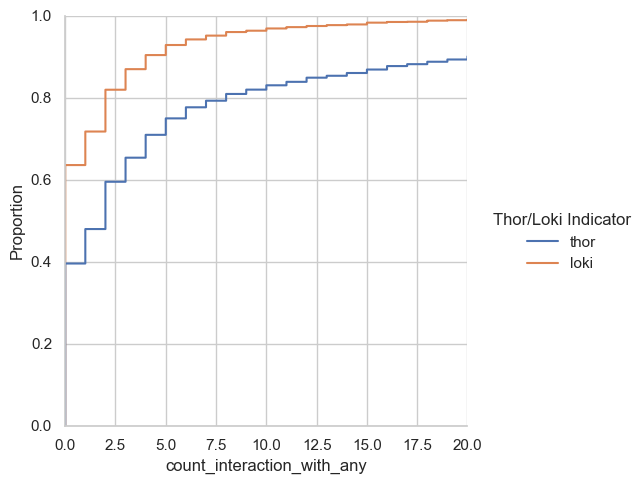

In [35]:
sns.set_theme(style="whitegrid")
sns.displot(df_loki, x="count_interaction_with_any", hue="Thor/Loki Indicator", kind="ecdf")
ax = plt.gca()
ax.set_xlim([0, 20])
plt.show()

50% of addresses in the Thor group have interacted with a pool at least 2 times
While only 10% of the Loki group have interacted with a pool at least 2 times

Above 5 interactions with a pool, we remove 90% of sybil users (Loki)

From these percentiles we can propose a threshold of the number of interactions with a dex should be around 5

Then a second threshold above 20 would eliminate 99% of the addresses that have the Loki flag and 90% of the addresses that have the Thor flag, however, that second stamp will give proof of humanness with a high degree of confidence.

The chart displays the percentiles of the number of interactions with a pool for the Thor/Loki data set per group of users.
It demonstrates visually that very rapidly when we increase the number of interactions almost all Loki addresses are filtered out.
We have to note that also many thor users don't have any transactions with a pool which would make the stamp discriminate against many users.

## Conclusion
Looking at the number of interactions with a decentralised exchange is a good way to filter out sybil users. However it is not enough to filter out all sybil users. Nonetheless, it would also filter out many thor users. Two kind of stamps could be issued one at a threshold of 5 interactions and one at 20 interactions.

### Verification with the Grant 15 data set

In [36]:
diff_address = np.setdiff1d(other_unique_address, loki_unique_address)

In [37]:
len(diff_address) + len(loki_unique_address)

5992

In [38]:
# Load gr15 transaction data
data_loader_gr15 = LoadData.LoadData(PATH_TO_EXPORT)
df_tx_15 = data_loader.create_df_tx('ethereum', other_unique_address.tolist())

In [ ]:
df_sybils_gr15_oss = pd.read_excel(PATH_TO_SYBILS_GR15, sheet_name=3)
df_sybils_gr15_eth = pd.read_excel(PATH_TO_SYBILS_GR15, sheet_name=4)
df_sybils_gr15_climate = pd.read_excel(PATH_TO_SYBILS_GR15, sheet_name=5)

In [53]:
# Append round 15 reviews
df_gr15 = pd.concat([df_sybils_gr15_oss[['Source Address', 'Reviewed Manually']], df_sybils_gr15_eth[['Source Address', 'Reviewed Manually']], df_sybils_gr15_climate[['Source Address', 'Reviewed Manually']]])

In [54]:
df_gr15.shape

(10167, 2)

In [55]:
df_gr15.drop_duplicates(subset=['Source Address', 'Reviewed Manually'], inplace=True)
print(df_gr15.shape[0])
print(df_gr15['Source Address'].nunique())

2013
1855


Some addresses reviewed manualy do not have the same flag, we will keep the sybil flag as the real flag.

For that we assign the flag true to the addresses that appear multiple times.

In [67]:
df_gr15.groupby('Source Address')

In [72]:
add_duplicate = (df_gr15.groupby('Source Address').count() > 1 ).reset_index()

In [74]:
arr_dup_address = add_duplicate[add_duplicate['Reviewed Manually'] == True]['Source Address'].values #here it is not reviewed manually but does it appear more than one time?

In [76]:
len(arr_dup_address)

158

In [80]:
df_gr15.loc[df_gr15['Source Address'].isin(arr_dup_address), 'Rewiewed Manually'] = True

In [81]:
df_gr15.drop_duplicates(subset=['Source Address'], inplace=True)
df_gr15.shape

(1855, 3)

In [82]:
df_gr15.value_counts('Reviewed Manually')

Reviewed Manually
False    1697
True      158
Name: count, dtype: int64

In comparison with the Thor/Loki data these data are very unbalanced.

In [85]:
tx_analyser_gr15 = txa(df_tx_15, df_address=pd.DataFrame(other_unique_address))
tx_analyser_gr15.set_group_by_sorted_EOA()

In [86]:
# Compute the number of interactions with any of the pools for each address in the loki dataset
df_gr15['count_interaction_with_any'] = df_gr15['Source Address'].apply(lambda x: count_interaction_with_any(tx_analyser_gr15, x, array_pool_address))

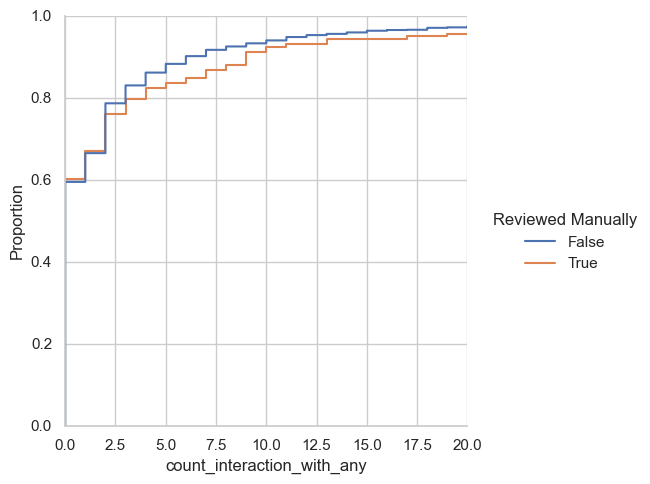

In [87]:
sns.set_theme(style="whitegrid")
sns.displot(df_gr15, x="count_interaction_with_any", hue='Reviewed Manually', kind="ecdf")
ax = plt.gca()
ax.set_xlim([0, 20])
plt.show()

Surprisingly the sybil percentile curve is below the non-sybil which is the contrary of the previous data set.

This can be explained by the fact that the data set is very unbalanced and that the sample of sybil is not representative of the whole population.